In [1]:
!pip install --quiet pytorch-lightning

     |████████████████████████████████| 798 kB 22.3 MB/s 
     |████████████████████████████████| 512 kB 59.1 MB/s 
     |████████████████████████████████| 125 kB 71.3 MB/s 
     |████████████████████████████████| 87 kB 4.2 MB/s 


In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from collections import Counter, OrderedDict

import cv2
import skimage
from skimage import img_as_ubyte
from skimage.io import imread
from PIL import Image

import torch
from torch import nn
from torch.nn import Sequential
from torch.nn import functional as F
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint

## Raw data explore

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!cp drive/MyDrive/Colab\ Notebooks/YSDA\ Sem\ 3/CV/11_Birds_segmentation/tests.zip tests.zip
!unzip -q tests.zip

img_train~(347, 500, 3), gt_train~(347, 500), img_test~(223, 320, 3), gt_test~(223, 320)


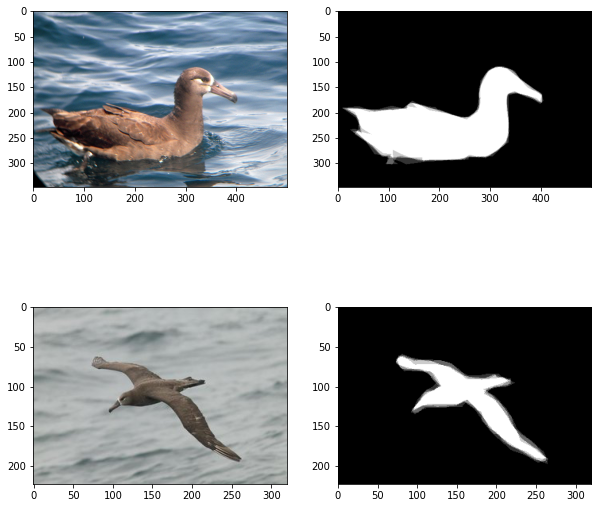

In [ ]:
img_train = imread('00_test_val_input/train/images/001.Black_footed_Albatross/Black_Footed_Albatross_0002_55.jpg')
gt_train = imread('00_test_val_input/train/gt/001.Black_footed_Albatross/Black_Footed_Albatross_0002_55.png')

img_test = imread('00_test_val_input/test/images/001.Black_footed_Albatross/Black_Footed_Albatross_0001_796111.jpg')
gt_test = imread('00_test_val_gt/001.Black_footed_Albatross/Black_Footed_Albatross_0001_796111.png')

print(f'img_train~{img_train.shape}, gt_train~{gt_train.shape}, img_test~{img_test.shape}, gt_test~{gt_test.shape}')

fig, ax = plt.subplots(2, 2, figsize=(10,10))
ax[0][0].imshow(img_train)
ax[0][1].imshow(gt_train, cmap='gray')
ax[1][0].imshow(img_test)
ax[1][1].imshow(gt_test, cmap='gray')
plt.show()

## Dataset

In [2]:
class BirdsDataset(Dataset):
    def __init__(self, 
                 mode: str,
                 fast_train: bool = True,
                 train_data_path: str = '00_test_val_input/train',
                 val_images_path: str = '00_test_val_input/test/images',
                 vat_gt_path: str = '00_test_val_gt',
                 normalize: bool = True
                ):
        self._items = []
        self._normalize = normalize
        
        train_path = os.path.join(train_data_path, 'images')
        gt_train_path = os.path.join(train_data_path, 'gt')

        birds_classes = sorted(os.listdir(train_path))

        # take only 1 class out of 200
        if fast_train:
            birds_classes = birds_classes[:1]

        for bird in birds_classes:
            if mode == 'train':
                filenames = sorted(os.listdir(os.path.join(train_path, bird)))
                for filename in filenames:
                    img_path = os.path.join(train_path, bird, filename)
                    gt_path = os.path.join(gt_train_path, bird, filename.replace('.jpg', '.png'))
                    self._items.append((img_path, gt_path))
            elif mode == 'val':
                filenames = sorted(os.listdir(os.path.join(val_images_path, bird)))
                for filename in filenames:
                    img_path = os.path.join(val_images_path, bird, filename)
                    gt_path = os.path.join(vat_gt_path, bird, filename.replace('.jpg', '.png'))
                    self._items.append((img_path, gt_path))
            else:
                raise ValueError('Wrong mode!')

    def __len__(self):
        return len(self._items)

    def __getitem__(self, index):
        img_path, gt_path = self._items[index]

        image = np.array(imread(img_path)).astype(np.float32)
        gt = np.array(img_as_ubyte(imread(gt_path, as_gray=True)) > 127).astype(np.float32)

        # resizing to 352x352
        image = cv2.resize(image, (352, 352))
        gt = cv2.resize(gt, (352, 352))

        # single channel image
        if len(image.shape) == 2:
            image = np.dstack([image]*3)

        # normalize and to tensor
        image = transforms.ToTensor()(image)
        gt = transforms.ToTensor()(gt)
        if self._normalize:
            image = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(image)

        return image, gt

img~torch.Size([3, 352, 352]), mask~torch.Size([1, 352, 352])


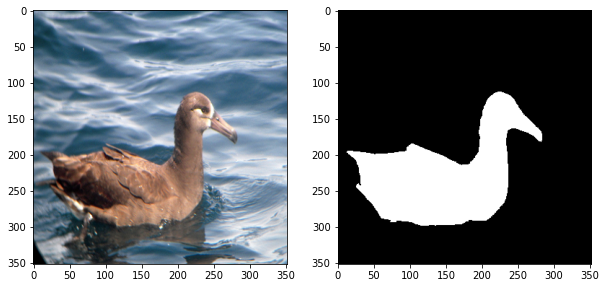

img~torch.Size([3, 352, 352]), mask~torch.Size([1, 352, 352])


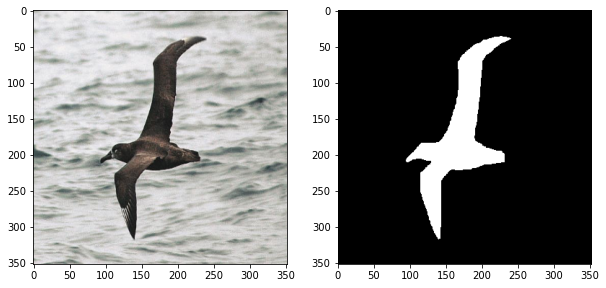

In [6]:
ds = BirdsDataset(mode="train", normalize=False)

for i, (im, mask) in enumerate(ds):
    print(f'img~{im.shape}, mask~{mask.shape}')
    fig, ax = plt.subplots(1, 2, figsize=(10,10))
    ax[0].imshow(im.cpu().numpy().transpose(1, 2, 0).astype(np.uint8))
    ax[1].imshow(mask.squeeze().cpu().numpy().astype(np.uint8), cmap='gray')
    plt.show()
    if i == 1:
        break

## Basic model

In [ ]:
def get_model():
    '''
    Get model for segmentation
    '''
    conv_1 = nn.Conv2d(3, 16, 3, padding='same')
    relu_1 = nn.ReLU()
    bn_1 = nn.BatchNorm2d(16)
    maxpool_1 = nn.MaxPool2d((2, 2), stride=2)
    conv_2 = nn.Conv2d(16, 32, 3, padding='same')
    relu_2 = nn.ReLU()
    bn_2 = nn.BatchNorm2d(32)
    maxpool_2 = nn.MaxPool2d((2, 2), stride=2)
    conv_3 = nn.Conv2d(32, 64, 3, padding='same')
    relu_3 = nn.ReLU()
    bn_3 = nn.BatchNorm2d(64)
    maxpool_3 = nn.MaxPool2d((2, 2), stride=2)
    conv_4 = nn.Conv2d(64, 128, 3, padding='same')
    relu_4 = nn.ReLU()
    bn_4 = nn.BatchNorm2d(128)
    maxpool_4 = nn.MaxPool2d((2, 2), stride=2)
    conv_5 = nn.Conv2d(128, 256, 3, padding='same')
    relu_5 = nn.ReLU()
    bn_5 = nn.BatchNorm2d(256)
    maxpool_5 = nn.MaxPool2d((2, 2), stride=2)

    upsample_1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
    deconv_1 = nn.Conv2d(256, 128, 3, padding='same')
    derelu_1 = nn.ReLU()
    debn_1 = nn.BatchNorm2d(128)
    upsample_2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
    deconv_2 = nn.Conv2d(128, 64, 3, padding='same')
    derelu_2 = nn.ReLU()
    debn_2 = nn.BatchNorm2d(64)
    upsample_3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
    deconv_3 = nn.Conv2d(64, 32, 3, padding='same')
    derelu_3 = nn.ReLU()
    debn_3 = nn.BatchNorm2d(32)
    upsample_4 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
    deconv_4 = nn.Conv2d(32, 16, 3, padding='same')
    derelu_4 = nn.ReLU()
    debn_4 = nn.BatchNorm2d(16)
    upsample_5 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
    deconv_5 = nn.Conv2d(16, 1, 1)

    model = Sequential(conv_1, relu_1, bn_1, maxpool_1, 
                       conv_2, relu_2, bn_2, maxpool_2,
                       conv_3, relu_3, bn_3, maxpool_3,
                       conv_4, relu_4, bn_4, maxpool_4,
                       conv_5, relu_5, bn_5, maxpool_5,
                       upsample_1, deconv_1, derelu_1, debn_1, 
                       upsample_2, deconv_2, derelu_2, debn_2,
                       upsample_3, deconv_3, derelu_3, debn_3,
                       upsample_4, deconv_4, derelu_4, debn_4,
                       upsample_5, deconv_5)
    return model

## Training

In [3]:
def get_iou(gt, pred):
    return (gt & pred).sum() / (gt | pred).sum()

def dice_loss(pred, target, smooth=1.):
    pred = pred.contiguous()
    target = target.contiguous()    
    intersection = (pred * target).sum(dim=2).sum(dim=2)
    summ = pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2)
    loss = (1 - (2 * intersection + smooth) / (summ + smooth)).mean()
    return loss

def predict(model, img_path):
    '''
    Returns matrix HxW with probabilities Object/Background
    '''
    image = np.array(imread(img_path)).astype(np.float32)
    shape = tuple(image.shape[:2])

    image = cv2.resize(image, (352, 352))
    if len(image.shape) == 2:
        image = np.dstack([image]*3)
    image = transforms.ToTensor()(image)
    image = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(image)
    image = image.unsqueeze(0)
    
    model.eval()
    with torch.no_grad():
        logits = model(image)

    pred = torch.sigmoid(logits)[0][0]
    pred = cv2.resize(pred.cpu().detach().numpy(), shape[::-1])
    return pred

In [ ]:
def train_segmentation_model(train_data_path):
    N_EPOCH = 10
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    model = get_model()
    model.to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-4)

    ds_train = BirdsDataset(mode="train", fast_train=True, train_data_path=train_data_path)
    ds_val = BirdsDataset(mode="val", fast_train=True, train_data_path=train_data_path)

    dl_train = DataLoader(ds_train, batch_size=32, shuffle=True, num_workers=2)
    dl_val = DataLoader(ds_val, batch_size=32, shuffle=False, num_workers=2)

    for epoch in range(N_EPOCH):
        train_loss = 0
        val_loss = 0

        model.train()
        for batch in dl_train:
            images, gt = batch
            images = images.to(DEVICE)
            gt = gt.to(DEVICE)

            logits = model(images)
            preds = torch.sigmoid(logits)
            loss = dice_loss(preds, gt)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        model.eval()
        with torch.no_grad():
            for batch in dl_val:
                images, gt = batch
                images = images.to(DEVICE)
                gt = gt.to(DEVICE)

                logits = model(images)
                preds = torch.sigmoid(logits)
                loss = dice_loss(preds, gt)

                val_loss += loss.item()

        train_loss /= len(dl_train)
        val_loss /= len(dl_val)
        print(f'[Epoch {epoch+1}] train_loss={train_loss:.4f}, val_loss={val_loss:.4f}')

    return model

In [ ]:
%%time
model = train_segmentation_model('00_test_val_input/train')

[Epoch 1] train_loss=0.7565, val_loss=0.7727
[Epoch 2] train_loss=0.6288, val_loss=0.7709
[Epoch 3] train_loss=0.6105, val_loss=0.7740
[Epoch 4] train_loss=0.6195, val_loss=0.7232
[Epoch 5] train_loss=0.5702, val_loss=0.6514
[Epoch 6] train_loss=0.5716, val_loss=0.5571
[Epoch 7] train_loss=0.5697, val_loss=0.5008
[Epoch 8] train_loss=0.5648, val_loss=0.4674
[Epoch 9] train_loss=0.5351, val_loss=0.4246
[Epoch 10] train_loss=0.5315, val_loss=0.4174
CPU times: user 2.31 s, sys: 2.72 s, total: 5.04 s
Wall time: 12.4 s


### Prediction

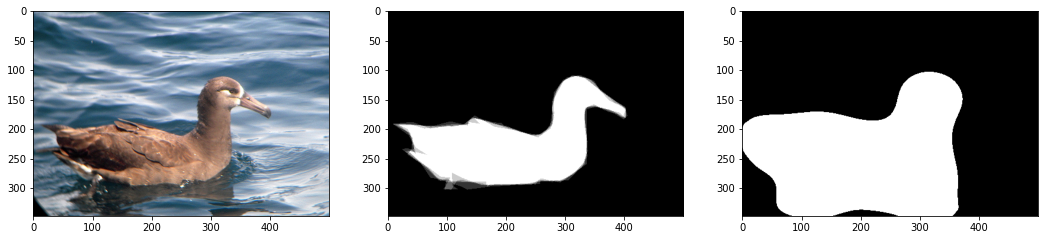

In [ ]:
img_path = '00_test_val_input/train/images/001.Black_footed_Albatross/Black_Footed_Albatross_0002_55.jpg'
gt_path = '00_test_val_input/train/gt/001.Black_footed_Albatross/Black_Footed_Albatross_0002_55.png'
img = imread(img_path)
gt = imread(gt_path)
model.to('cpu')
pred = predict(model, img_path)
pred = (pred > 0.5).astype(np.uint8) * 255

fig, ax = plt.subplots(1, 3, figsize=(18,10))
ax[0].imshow(img)
ax[1].imshow(gt, cmap='gray')
ax[2].imshow(pred, cmap='gray')

In [ ]:
print(f'IoU = {get_iou(gt, pred):.3f}')

IoU = 0.508


## U-Net + pre-trained ResNet

In [7]:
def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
    )

class ResNetUNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.base_model = models.resnet18(weights='IMAGENET1K_V1')
        self.base_layers = list(self.base_model.children())

        self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)
        self.layer1_1x1 = convrelu(64, 64, 1, 0)
        self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)
        self.layer2_1x1 = convrelu(128, 128, 1, 0)
        self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)
        self.layer3_1x1 = convrelu(256, 256, 1, 0)
        self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
        self.layer4_1x1 = convrelu(512, 512, 1, 0)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

        self.conv_last = nn.Conv2d(64, 1, 1)

    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)

        layer0 = self.layer0(input)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)

        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)

        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)

        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)

        out = self.conv_last(x)

        return out

class MyModel(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.model = ResNetUNet()
        self.bce_weight = 0.6

        # freeze all backbone layers
        for l in self.model.base_layers:
            for param in l.parameters():
                param.requires_grad = False

    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_logit = self(x)
        bce = F.binary_cross_entropy_with_logits(y_logit, y)
        pred = torch.sigmoid(y_logit)
        dice = dice_loss(pred, y)
        loss = bce * self.bce_weight + dice * (1 - self.bce_weight) * y.size(0)
        return {'loss': loss}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_logit = self(x)
        bce = F.binary_cross_entropy_with_logits(y_logit, y)
        pred = torch.sigmoid(y_logit)
        dice = dice_loss(pred, y)
        # 0.6 weight for BCE, 0.4 for Dice
        loss = bce * self.bce_weight + dice * (1 - self.bce_weight) * y.size(0)
        return {'val_loss': loss, 'logs': {'dice': dice, 'bce': bce}}

    def training_epoch_end(self, outputs):
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        print(f"| Train_loss: {avg_loss:.3f}" )
        self.log('train_loss', avg_loss, prog_bar=True, on_epoch=True, on_step=False)
     
    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        avg_dice = torch.stack([x['logs']['dice'] for x in outputs]).mean()
        avg_bce = torch.stack([x['logs']['bce'] for x in outputs]).mean()
        print(f"[Epoch {self.trainer.current_epoch:3}] Val_loss: {avg_loss:.3f}, Val_dice: {avg_dice:.3f}, Val_bce: {avg_bce:.3f}", end= " ")
        self.log('val_loss', avg_loss, prog_bar=True, on_epoch=True, on_step=False)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=5e-4)
        
        lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,
                                                              gamma=0.96,
                                                              verbose=True)
        lr_dict = {
            "scheduler": lr_scheduler,
            "interval": "epoch",
            "frequency": 3,
            "monitor": "val_loss"
        } 
        return [optimizer], [lr_dict]

def get_model():
    return MyModel()

## Training

In [8]:
def train_segmentation_model(train_data_path):
    '''
    Train segmentation model
    '''
    ds_train = BirdsDataset(mode="train", fast_train=False, train_data_path=train_data_path)
    ds_val = BirdsDataset(mode="val", fast_train=False, train_data_path=train_data_path)

    dl_train = DataLoader(ds_train, batch_size=32, shuffle=True, num_workers=2)
    dl_val = DataLoader(ds_val, batch_size=32, shuffle=False, num_workers=2)

    model = get_model()

    MyModelCheckpoint = ModelCheckpoint(dirpath='runs/pl_segmentation',
                                        filename='{epoch}-{val_loss:.3f}',
                                        monitor='val_loss', 
                                        mode='min', 
                                        save_top_k=1)

    MyEarlyStopping = EarlyStopping(monitor="val_loss",
                                    mode="min",
                                    patience=5,
                                    verbose=True)
    
    trainer = pl.Trainer(max_epochs=30,
                         accelerator='gpu',
                         devices=1,
                         precision=16,
                         logger=True,
                         enable_checkpointing=True,
                         callbacks=[MyEarlyStopping, MyModelCheckpoint])

    trainer.fit(model, dl_train, dl_val)

    # setting weights <1e-38 to zero, if there're
    with torch.no_grad():
        for name, param in model.model.named_parameters():
            if not name.startswith('base_model'):
                param[param.abs() < np.finfo('float32').tiny] = 0.

    torch.save(model.to('cpu').state_dict(), "segmentation_model.pth")

    return model

In [9]:
model = train_segmentation_model('00_test_val_input/train')

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit native Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type       | Params
-------------------------------------
0 | model | ResNetUNet | 18.3 M
-------------------------------------
6.6 M     Trainable params
11.7 M    Non-trainable params
18.3 M    Total params
36.626    Total estimated model params size (MB)


Adjusting learning rate of group 0 to 1.0000e-03.


Sanity Checking: 0it [00:00, ?it/s]

[Epoch   0] Val_loss: 15.606, Val_dice: 0.693, Val_bce: 11.235 

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 1.521


[Epoch   0] Val_loss: 1.521, Val_dice: 0.112, Val_bce: 0.147 | Train_loss: 3.362


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.155 >= min_delta = 0.0. New best score: 1.365


[Epoch   1] Val_loss: 1.365, Val_dice: 0.100, Val_bce: 0.140 | Train_loss: 1.410
Adjusting learning rate of group 0 to 9.6000e-04.


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.143 >= min_delta = 0.0. New best score: 1.223


[Epoch   2] Val_loss: 1.223, Val_dice: 0.090, Val_bce: 0.130 | Train_loss: 1.234


Validation: 0it [00:00, ?it/s]

[Epoch   3] Val_loss: 1.270, Val_dice: 0.094, Val_bce: 0.116 | Train_loss: 1.128


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.050 >= min_delta = 0.0. New best score: 1.173


[Epoch   4] Val_loss: 1.173, Val_dice: 0.085, Val_bce: 0.137 | Train_loss: 1.063
Adjusting learning rate of group 0 to 9.2160e-04.


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.095 >= min_delta = 0.0. New best score: 1.078


[Epoch   5] Val_loss: 1.078, Val_dice: 0.079, Val_bce: 0.106 | Train_loss: 1.008


Validation: 0it [00:00, ?it/s]

[Epoch   6] Val_loss: 1.141, Val_dice: 0.084, Val_bce: 0.119 | Train_loss: 0.965


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.053 >= min_delta = 0.0. New best score: 1.025


[Epoch   7] Val_loss: 1.025, Val_dice: 0.075, Val_bce: 0.105 | Train_loss: 0.932
Adjusting learning rate of group 0 to 8.8474e-04.


Validation: 0it [00:00, ?it/s]

[Epoch   8] Val_loss: 1.143, Val_dice: 0.084, Val_bce: 0.108 | Train_loss: 0.919


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 1.010


[Epoch   9] Val_loss: 1.010, Val_dice: 0.074, Val_bce: 0.110 | Train_loss: 0.895


Validation: 0it [00:00, ?it/s]

[Epoch  10] Val_loss: 1.040, Val_dice: 0.076, Val_bce: 0.112 | Train_loss: 0.868
Adjusting learning rate of group 0 to 8.4935e-04.


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 0.981


[Epoch  11] Val_loss: 0.981, Val_dice: 0.072, Val_bce: 0.104 | Train_loss: 0.840


Validation: 0it [00:00, ?it/s]

[Epoch  12] Val_loss: 0.997, Val_dice: 0.073, Val_bce: 0.098 | Train_loss: 0.837


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.978


[Epoch  13] Val_loss: 0.978, Val_dice: 0.072, Val_bce: 0.104 | Train_loss: 0.800
Adjusting learning rate of group 0 to 8.1537e-04.


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.971


[Epoch  14] Val_loss: 0.971, Val_dice: 0.071, Val_bce: 0.104 | Train_loss: 0.785


Validation: 0it [00:00, ?it/s]

[Epoch  15] Val_loss: 0.984, Val_dice: 0.072, Val_bce: 0.109 | Train_loss: 0.781


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 0.947


[Epoch  16] Val_loss: 0.947, Val_dice: 0.069, Val_bce: 0.103 | Train_loss: 0.788
Adjusting learning rate of group 0 to 7.8276e-04.


Validation: 0it [00:00, ?it/s]

[Epoch  17] Val_loss: 0.960, Val_dice: 0.070, Val_bce: 0.098 | Train_loss: 0.752


Validation: 0it [00:00, ?it/s]

[Epoch  18] Val_loss: 0.980, Val_dice: 0.072, Val_bce: 0.110 | Train_loss: 0.772


Validation: 0it [00:00, ?it/s]

[Epoch  19] Val_loss: 0.949, Val_dice: 0.070, Val_bce: 0.100 | Train_loss: 0.744
Adjusting learning rate of group 0 to 7.5145e-04.


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.939


[Epoch  20] Val_loss: 0.939, Val_dice: 0.069, Val_bce: 0.095 | Train_loss: 0.731


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 0.920


[Epoch  21] Val_loss: 0.920, Val_dice: 0.068, Val_bce: 0.095 | Train_loss: 0.725


Validation: 0it [00:00, ?it/s]

[Epoch  22] Val_loss: 0.947, Val_dice: 0.070, Val_bce: 0.096 | Train_loss: 0.709
Adjusting learning rate of group 0 to 7.2139e-04.


Validation: 0it [00:00, ?it/s]

[Epoch  23] Val_loss: 0.952, Val_dice: 0.069, Val_bce: 0.108 | Train_loss: 0.701


Validation: 0it [00:00, ?it/s]

[Epoch  24] Val_loss: 0.938, Val_dice: 0.068, Val_bce: 0.108 | Train_loss: 0.703


Validation: 0it [00:00, ?it/s]

[Epoch  25] Val_loss: 0.927, Val_dice: 0.068, Val_bce: 0.097 | Train_loss: 0.719
Adjusting learning rate of group 0 to 6.9253e-04.


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 5 records. Best score: 0.920. Signaling Trainer to stop.


[Epoch  26] Val_loss: 0.957, Val_dice: 0.070, Val_bce: 0.104 | Train_loss: 0.690


In [ ]:
# !cp segmentation_model.pth drive/MyDrive/segmentation_model.pth

### Prediction

In [ ]:
# Load trained model and check prediction
# !cp drive/MyDrive/Colab\ Notebooks/YSDA\ Sem\ 3/CV/11_Birds_segmentation/segmentation_model.pth segmentation_model.pth

In [ ]:
# model = get_model()
# model.load_state_dict(torch.load("segmentation_model.pth"))

<All keys matched successfully>

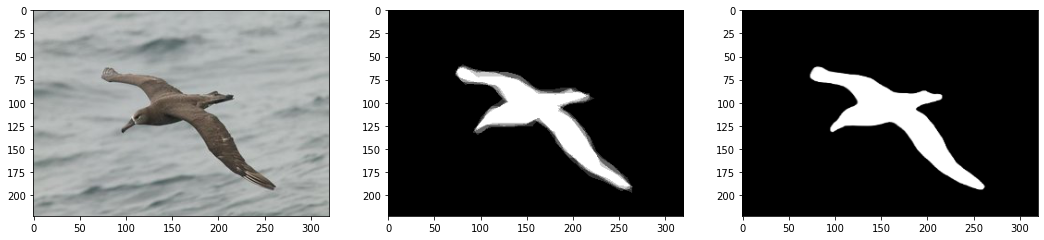

In [10]:
# img_path = '00_test_val_input/train/images/001.Black_footed_Albatross/Black_Footed_Albatross_0002_55.jpg'
# gt_path = '00_test_val_input/train/gt/001.Black_footed_Albatross/Black_Footed_Albatross_0002_55.png'
img_path = '00_test_val_input/test/images/001.Black_footed_Albatross/Black_Footed_Albatross_0001_796111.jpg'
gt_path = '00_test_val_gt/001.Black_footed_Albatross/Black_Footed_Albatross_0001_796111.png'

img = imread(img_path)
gt = imread(gt_path)
pred = predict(model, img_path)

fig, ax = plt.subplots(1, 3, figsize=(18,10))
ax[0].imshow(img)
ax[1].imshow(gt, cmap='gray')
ax[2].imshow(pred, cmap='gray')

In [11]:
pred_frmt = (pred > 0.5).astype('uint8') * 255
print(f'IoU = {get_iou(gt, pred_frmt):.3f}')

IoU = 0.855


In [12]:
# Ideally, should be less than 1 second
%timeit predict(model, img_path)

1.5 s ± 10.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
